## Multinomial Classification of Grammatical Structuresin English according to CEFR

Please make sure that utils.py file exist in the same directory.

In [1]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.feature_extraction.text import 
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
import re
from utils import *

In [2]:
# importing datset with merged categories
english_profile = pd.read_csv('./merged_labels_fixed.csv', sep='\t', index_col=0)
english_profile.head()

,Sentence,Level
0,The teachers are very nice and friendly .,A
1,I like my house because it is big and comforta...,A
2,You can buy Turkish and English products as we...,A
3,The weather was cloudy but fine.,A
4,It was cheap but beautiful.,A


In [4]:
def trainer(english_profile, vec='count', classifier='lr', feature='words', binarize=True, class_w=True, res=True):
    '''
    Input: pandas dataframe of sentences and labels
    Param: 
        vect: count = 'Bag-of-words' word vectorization model
              tfidf = tfidf
        classifier = 'dummy' for random classifier or 'lr' logisitic regression
        
        feature: words = tokenized word, mixed = sentence with some of their words replaced with POS tags (masked)
        ######## the 3 param. below are used to make the function usable in both phases.
        binarize: forces datatype of label to be integer. 
        class_w: applies weight to certain gold_label classes to avoid data imbalance
        res: show plots
    '''
    
    #tokenizing the sentences in the dataframe
    english_profile['tokens'] = english_profile.Sentence.apply(posify, args=(feature,))
    #Applying Bag-of-Words Model of 1-gram, 2-gram, 3-gram
    if vec == 'count':
        vectorizer = CountVectorizer(lowercase=False, ngram_range=(1, 3))
    if vec == 'tfidf':
        vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1, 3))

    mat = vectorizer.fit_transform(english_profile['tokens'])
    # binarize gold label
    if binarize:
        english_profile['label'] = english_profile.Level.apply(convert)
    else:
        english_profile['label'] = english_profile['label'].apply(lambda x:int(x))
    # spliting data into training and test
    X_train, X_test, y_train, y_test = train_test_split(mat, english_profile['label'] , test_size=0.33, random_state=42)
    # fitting logisitc regression model
    if classifier=='dummy':
        mul_lr = DummyClassifier()
    if classifier=='lr':
        if class_w:
            mul_lr = LogisticRegression(multi_class='multinomial', \
                                                 solver='newton-cg',n_jobs=-1, random_state=42,\
                                                 class_weight={1:0.1,2:0.1,3:0.8})
        else:
            mul_lr = LogisticRegression(multi_class='multinomial', \
                                                 solver='newton-cg',n_jobs=-1, random_state=42)

    mul_lr.fit(X_train, y_train)
    if res:
        print("Test Accuracy of % Train : ".format(classifier), accuracy_score(y_train, mul_lr.predict(X_train)))
        print("Test Accuracy of % Train : ".format(classifier), accuracy_score(y_test, mul_lr.predict(X_test)))
        print(classification_report(y_test, mul_lr.predict(X_test)))
        cnf_matrix = confusion_matrix(y_test, mul_lr.predict(X_test))
        np.set_printoptions(precision=2)
        # Plot normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=['A',"B","C"], normalize=True,
                          title='Normalized confusion matrix')

        plt.show()
    return vectorizer, mul_lr


Test Accuracy of % Train :  0.9884393063583815
Test Accuracy of % Train :  0.694048616932104
             precision    recall  f1-score   support

          1       0.71      0.78      0.74       371
          2       0.74      0.64      0.69       607
          3       0.57      0.70      0.63       215

avg / total       0.70      0.69      0.69      1193

Normalized confusion matrix
[[0.78 0.21 0.02]
 [0.18 0.64 0.17]
 [0.03 0.27 0.7 ]]


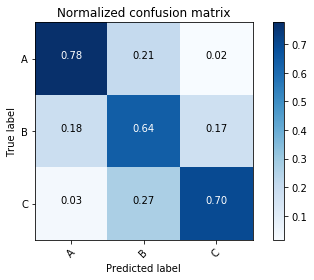

(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=False, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 3), preprocessor=None, stop_words=None,
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None),
 LogisticRegression(C=1.0, class_weight={1: 0.1, 2: 0.1, 3: 0.8}, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='multinomial', n_jobs=-1, penalty='l2',
           random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
           warm_start=False))

In [5]:
trainer(english_profile, vec='count', classifier='lr', feature='words', binarize=True)

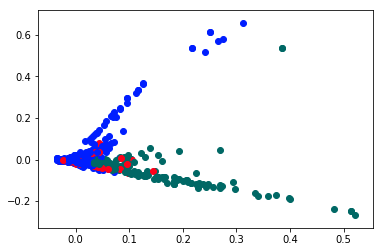

In [6]:
# projecting using K-means and PCA
project(english_profile.Sentence,3)

In [7]:
# loading the unlabelled corpus
with open("brown_corpus.txt") as file:
    txt_file = file.read()

# removing weird encoding characters
cleaned = re.sub('_.+?_|#.+|\n', '', txt_file)

# tokenize sentences
sents = nltk.tokenize.sent_tokenize(cleaned)

# tokenize words within each sentences. flag can take: words or mixed.
sents_posified = [posify(s, flag='words') for s in sents if len(s.split(' ')) < 30] 


In [12]:
len(sents_posified)

38590

In [31]:
# res is set to false because I don't to show plots. I only need to the vectorizer to transform my data for prediction. 
# Similarly, I need the classifier object to make inferences on the unlabelled data.
vectorizer, mul_lr = trainer(english_profile, vec='count', classifier='lr', \
                             feature='words', binarize=True, res=False)

#transforming my new data to match the dimensions of BoW matrix
brown_corpus = vectorizer.transform(sents_posified)

# create new dataframe to contain the sentences from the unlabelled sentences, and their predicted label.
corpus_df = pd.DataFrame([sents_posified, mul_lr.predict(brown_corpus).tolist()]).transpose()

# I also use the LR classifier to output the classification probability of each predicted label 
# and use them as confidance score.
corpus_df['confidence'] = mul_lr.predict_proba(brown_corpus).tolist()

indivd_conf_score = list()
idx = corpus_df[1].tolist()
for i,j in enumerate(corpus_df.confidence):
    indivd_conf_score.append(j[idx[i]-1])

corpus_df['conf_score'] = indivd_conf_score

# filtering out low-prob scores
filtered_df = corpus_df.loc[corpus_df['conf_score'] > 0.9]

d1 = pd.DataFrame(english_profile[['Sentence','label']], columns=['Sentence','label'])
d2 = pd.DataFrame(filtered_df[[0,1]])
d2.columns = ['Sentence','label']

combined_dataset = d1.append(d2)

In [36]:
# this data set is a combination of my original dataset + 1000-ish sentences predicted from 
#the unlabelled corpus with prob. > 0.9
combined_dataset.head()

,Sentence,label
0,The teachers are very nice and friendly .,1
1,I like my house because it is big and comforta...,1
2,You can buy Turkish and English products as we...,1
3,The weather was cloudy but fine.,1
4,It was cheap but beautiful.,1


Test Accuracy of % Train :  0.9997039668442865
Test Accuracy of % Train :  0.7903903903903904
             precision    recall  f1-score   support

          1       0.72      0.79      0.76       392
          2       0.71      0.74      0.72       594
          3       0.92      0.83      0.87       679

avg / total       0.80      0.79      0.79      1665

Normalized confusion matrix
[[0.79 0.2  0.01]
 [0.18 0.74 0.08]
 [0.02 0.15 0.83]]


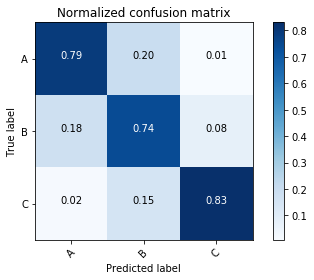

(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=False, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 3), preprocessor=None, stop_words=None,
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='multinomial',
           n_jobs=-1, penalty='l2', random_state=42, solver='newton-cg',
           tol=0.0001, verbose=0, warm_start=False))

In [20]:
# training a TOTALLY NEW logisitic regression classifier on the combined (augmented) dataset
# Please note that this is a new training process. The function, defined above, has its own vectorization \
# methods as well as training and testing
trainer(combined_dataset, vec='count', classifier='lr', feature='words',binarize=False, class_w=False)